# Generalization experiment
Here we load the pre-trained model and test them. In particular, we consider Multi-layers Perceptrons with different activations:
1. Tanh
2. ReLU
3. Snake
And also the architecture of
4. SIREN

In [1]:
import torch 
import torch.nn as nn 
from warnings import warn
import matplotlib.pyplot as plt

# Relative import
folders_back = 2
import sys; sys.path.append(folders_back*'../')
from src.activations import *
from src.hypersolvers import TanhHyperSolver, ReLUHyperSolver, SnakeHyperSolver
from src.controllers import *
from src.env.classic_control import Pendulum
# device = torch.device('cuda:1' if(torch.cuda.is_available()) else 'cpu')
device = torch.device('cpu') # override
print('Device:', device)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

Device: cpu


In [2]:
 # Reinitialize
bs = 1000

U = RandConstController([bs, 1], -3, 3)
sys = Pendulum(U)

In [3]:
# Loading
hs_tanh = torch.load('saved_models/hs_tanh.pt')
hs_relu = torch.load('saved_models/hs_relu.pt')
hs_siren = torch.load('saved_models/hs_siren.pt')
hs_snake = torch.load('saved_models/hs_snake.pt')


In [4]:
    
from torchdiffeq import odeint as odeint

def compute_residual(t, Δt, x, u, hs, model='SIREN', method='dopri5'):
    """
    x: u_batch, batch, dimr
    u: u_batch, batch, dim
    """
    t_span = torch.tensor([t, t + Δt]).to(x)
    sys.u.u0 = u
    f = sys._dynamics(t, x)

    if x.shape == u.shape or u.shape[1] == 16:  # plots
        xfu = torch.cat([x, f, u], -1)
    else:
        xfu = torch.cat([x, f, u.repeat(1, x.shape[1], 1)], -1)
    
    xfu = torch.cat([x, f, u], -1)
    if model == 'SIREN':
        g, _ = hs(xfu) # unpack for SIREN coord (unused)
    elif model == 'euler':
        g = 0
    else:
        g = hs(xfu)
    zd = odeint(sys._dynamics, x, t_span, method=method).squeeze(0)[-1]
    z  = sys(x, t_span).squeeze(0)[-1]
  
    R = (zd - z)/(Δt**2)
    L = torch.norm(R - g, dim=-1, p=2)
    return L                  

## Generalization on across state space

/home/botu/anaconda3/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


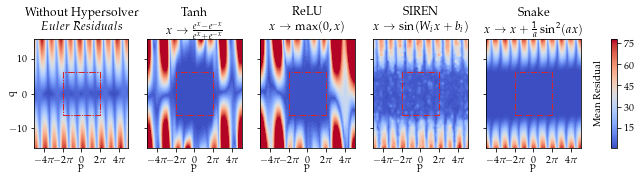

In [5]:
from matplotlib import colors, cm
from matplotlib.patches import Rectangle
edgecolor = 'tab:red'
from math import pi
x_min_train, x_max_train = -2*pi, 2*pi
x_min_plot, x_max_plot = -5*pi, 5*pi # we plot unexplored regions
t = 0
Δt = 0.1
n_grid = 100 ; u_b = 10
u_grid = torch.linspace(-u_b, u_b, n_grid).unsqueeze(1)

fig, axs = plt.subplots(1, 5, figsize=(11, 2))

cmap = 'coolwarm'
n_grid = 50

# Create control inputs to show
u = torch.arange(-8, 8, 1)
u = u.reshape(1, torch.numel(u)).repeat(n_grid**2, 1)
u = u[..., None]

# Create mesh of x
xx = torch.linspace(x_min_plot, x_max_plot, n_grid)
x0, x1 = torch.meshgrid(xx, xx)
x = torch.cat([x0.reshape(-1, 1), x1.reshape(-1, 1)], 1)
x = x[:, None, :].repeat(1, u.shape[1], 1)

r = compute_residual(t, Δt, x, u, hs_tanh, model='euler').detach()
I = axs[0].contourf(x0, x1, r[...,8].reshape(
    n_grid, n_grid), 100, cmap=cmap)
# Add rectangle to show where we are training the system
axs[0].add_patch(Rectangle((x_min_train, x_min_train), x_max_train-x_min_train,
    x_max_train-x_min_train, edgecolor=edgecolor, fill=False, lw=1, ls='-.'))
vmax = I.get_array().max()
norm = colors.Normalize(vmin=0, vmax=vmax)

# fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[0], fraction=.1)

# Euler
r = compute_residual(t, Δt, x, u, hs_tanh, model='euler').detach()
I = axs[0].contourf(x0, x1, r[...,8].reshape(
    n_grid, n_grid), 100, cmap=cmap)
# Add rectangle to show where we are training the system
axs[0].add_patch(Rectangle((x_min_train, x_min_train), x_max_train-x_min_train,
    x_max_train-x_min_train, edgecolor=edgecolor, fill=False, lw=1, ls='-.'))
vmax = I.get_array().max()
norm = colors.Normalize(vmin=0, vmax=vmax)
for c in I.collections: # rasterize to reduce size
    c.set_rasterized(True)
cb = fig.colorbar(I, ax=axs, location='right', fraction=0.06)

    
# Tanh
r = compute_residual(t, Δt, x, u, hs_tanh, model='tanh').detach()
I = axs[1].contourf(x0, x1, r[...,8].reshape(
    n_grid, n_grid), 100, cmap=cmap, norm=norm)
# Add rectangle to show where we are training the system
axs[1].add_patch(Rectangle((x_min_train, x_min_train), x_max_train-x_min_train,
    x_max_train-x_min_train, edgecolor=edgecolor, fill=False, lw=1, ls='-.'))
for c in I.collections:
    c.set_rasterized(True)

# ReLU
r = compute_residual(t, Δt, x, u, hs_relu, model='relu').detach()
I = axs[2].contourf(x0, x1, r[...,8].reshape(
    n_grid, n_grid), 100, cmap=cmap, norm=norm)
# Add rectangle to show where we are training the system
axs[2].add_patch(Rectangle((x_min_train, x_min_train), x_max_train-x_min_train,
    x_max_train-x_min_train, edgecolor=edgecolor, fill=False, lw=1, ls='-.'))
for c in I.collections: # rasterize to reduce size
    c.set_rasterized(True)

# SIREN
r = compute_residual(t, Δt, x, u, hs_siren, model='SIREN').detach()
I = axs[3].contourf(x0, x1, r[...,8].reshape(
    n_grid, n_grid), 100, cmap=cmap)
# Add rectangle to show where we are training the system
axs[3].add_patch(Rectangle((x_min_train, x_min_train), x_max_train-x_min_train,
    x_max_train-x_min_train, edgecolor=edgecolor, fill=False, lw=1, ls='-.'))
for c in I.collections: # rasterize to reduce size
    c.set_rasterized(True)
    
# Snake
r = compute_residual(t, Δt, x, u, hs_snake, model='snake').detach()
I = axs[4].contourf(x0, x1, r[...,8].reshape(
    n_grid, n_grid), 100, cmap=cmap)
# Add rectangle to show where we are training the system
axs[4].add_patch(Rectangle((x_min_train, x_min_train), x_max_train-x_min_train,
    x_max_train-x_min_train, edgecolor=edgecolor, fill=False, lw=1, ls='-.'))
for c in I.collections: # rasterize to reduce size
    c.set_rasterized(True)


    
from matplotlib import ticker
tick_locator = ticker.MaxNLocator(nbins=7)
cb.locator = tick_locator
cb.update_ticks()

# cb.ax.set_xticklabels([0, 20, 40, 60, 80])
cb.set_label('Mean Residual',rotation=90, labelpad=-40)

plt.setp(axs, xticks=[-4*pi, -2*pi, 0, 2*pi, 4*pi], xticklabels=['$-4\pi$', r'$-2\pi$', r'$0$', r'$2\pi$', r'$4\pi$'])

titles = [f'Without Hypersolver\n$Euler~Residuals$', 
        r'Tanh' '\n' r' $x \to \frac{e^x - e^{-x}}{e^x + e^{-x}}$', 
         r'ReLU' '\n' r'$ x \to \max(0, x)$',
          r'SIREN' '\n' r'$ x\to \sin(W_i x + b_i) $',
         r'Snake' '\n' r'$x \to x + \frac{1}{a} \sin^2(ax)$']

title_pads = [10, 0, 10, 10, 7]
pad = 5 # in points

for ax, title, title_pad in zip(axs, titles, title_pads):
    ax.set_xlabel(r'p', labelpad=-4)
    ax.set_ylabel(r'q', labelpad=-8)
    ax.set_title(title, fontweight='bold', pad=title_pad)
    ax.label_outer()
    
# fig.suptitle(r'Hypersolver Residuals with Different Activation Functions', y=1.08, fontsize=20, fontweight='bold')


# Set the ticks and ticklabels for all axes
#             yticks=[-4*pi, -2*pi, 0, 2*pi, 4*pi], yticklabels=['$-4\pi$', r'$-2\pi$', r'$0$', r'$2\pi$', r'$4\pi$'])

## Saving
import tikzplotlib
fig.savefig('media/generalization_state.pdf',  bbox_inches = 'tight')
tikzplotlib.save("media/generalization_state.tex")

## Generalization across controller space

In [6]:
from torchdiffeq import odeint as odeint

def compute_residual(t, Δt, x, u, hs, model='siren', method='dopri5'):
    """
    x: u_batch, batch, dimr
    u: u_batch, batch, dim
    """
    t_span = torch.tensor([t, t + Δt]).to(x)
    sys.u.u0 = u
    f = sys._dynamics(t, x)
    zd = odeint(sys._dynamics, x, t_span, method='dopri5').squeeze(0)[-1] # accurate solver

    if method == 'euler' or method == 'midpoint' or method == 'rk4':
        z = odeint(sys._dynamics, x, t_span, method=method).squeeze(0)[-1]
        R = (zd - z)/(Δt**2)
        return torch.norm(R, dim=-1, p=2)

    # Modify this for the plots!
    xfu = torch.cat([x, f, u], -1)
    # xfu = torch.cat([x, f, u.repeat(1, x.shape[1], 1)], -1)
    
    xfu = torch.cat([x, f, u], -1)
    if model.lower() == 'siren':
        g, _ = hs(xfu) # unpack for SIREN coord (unused)
    else:
        g = hs(xfu)
    
 
    z  = sys(x, t_span).squeeze(0)[-1]

    R = (zd - z)/(Δt**2)
    L = torch.norm(R - g, dim=-1, p=2)
    return L                  

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


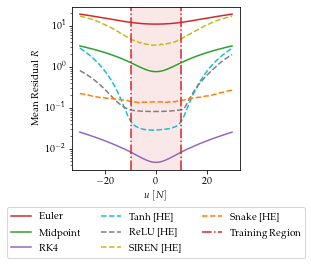

In [7]:
from matplotlib import colors, cm
from matplotlib.patches import Rectangle

from math import pi
x_min_train, x_max_train = -2*pi, 2*pi
t = 0
Δt = 0.1

# Controller values: originally from -10, 10
n_grid = 100 ; u_b = 30 # 10
u_grid = torch.linspace(-u_b, u_b, n_grid)[..., None]
u_grid = u_grid.repeat(n_grid**2, 1, 1)
u = u_grid


# # Create control inputs to show
# u = torch.arange(-8, 8, 1)
# u = u.reshape(1, torch.numel(u)).repeat(n_grid**2, 1)
# u = u[..., None]

# Create mesh of x
xx = torch.linspace(x_min_train, x_max_train, n_grid)
x0, x1 = torch.meshgrid(xx, xx)
x = torch.cat([x0.reshape(-1, 1), x1.reshape(-1, 1)], 1)
x = x[:, None, :].repeat(1, u.shape[1], 1)

# print(u_grid.shape, x.shape)
fig, ax = plt.subplots(1, 1, figsize=(3,3))

grid = torch.linspace(-u_b, u_b, n_grid)
# Fixed-step solvers
r = compute_residual(t, Δt, x, u, hs_tanh, method='euler').detach()
ax.plot(grid, r.mean(0), color='tab:red', label='Euler')
r = compute_residual(t, Δt, x, u, hs_snake, method='midpoint').detach()
ax.plot(grid, r.mean(0), color='tab:green', label='Midpoint')
r = compute_residual(t, Δt, x, u, hs_snake, method='rk4').detach()
ax.plot(grid, r.mean(0), color='tab:purple', label='RK4')

# Hypersolvers
r = compute_residual(t, Δt, x, u, hs_tanh, model='tanh').detach()
ax.plot(grid, r.mean(0), color='tab:cyan',  linestyle='--',label='Tanh [HE]')
r = compute_residual(t, Δt, x, u, hs_relu, model='relu').detach()
ax.plot(grid, r.mean(0), color='tab:gray',linestyle='--', label='ReLU [HE]')
r = compute_residual(t, Δt, x, u, hs_siren, model='siren').detach()
ax.plot(grid, r.mean(0), color='tab:olive', linestyle='--', label='SIREN [HE]')
r = compute_residual(t, Δt, x, u, hs_snake, model='snake').detach()
ax.plot(grid, r.mean(0), color='tab:orange',linestyle='--', label='Snake [HE]')

ax.axvline(x=-10, color='tab:red', linestyle='-.')
ax.axvline(x=10, color='tab:red', linestyle='-.', label='Training Region')
ax.axvspan(-10, 10, alpha=0.1, color='tab:red')

ax.set_yscale('log')
ax.set_xlabel(f'$u~[N]$')
ax.set_ylabel(f'Mean Residual $R$')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=False, ncol=3)
# ## Saving
import tikzplotlib
fig.savefig('media/generalization_controller.pdf',  bbox_inches = 'tight')
tikzplotlib.save("media/generalization_controller.tex")

## Generalization across step sizes

In [8]:
from matplotlib import colors, cm
from matplotlib.patches import Rectangle
from tqdm import tqdm
from math import pi
x_min_train, x_max_train = -2*pi, 2*pi
t = 0
Δt = 0.1
t_list = torch.logspace(-4, 0, 201)


# Controller values: originally from -10, 10
n_grid = 50 ; u_b = 10 # 10
u_grid = torch.linspace(-u_b, u_b, n_grid)[..., None]
u_grid = u_grid.repeat(n_grid**2, 1, 1)
u = u_grid

# Create mesh of x
xx = torch.linspace(x_min_train, x_max_train, n_grid)
x0, x1 = torch.meshgrid(xx, xx)
x = torch.cat([x0.reshape(-1, 1), x1.reshape(-1, 1)], 1)
x = x[:, None, :].repeat(1, u.shape[1], 1)



def compute_residual_different_steps(t, t_list, x, u, hs, **kwargs):
    r = []
    for dt in tqdm(t_list):
        r.append(compute_residual(t, dt, x, u, hs, **kwargs).detach()[...,None])
    return torch.cat(r, -1)

fig, ax = plt.subplots(1, 1, figsize=(3,3))

grid = torch.linspace(-u_b, u_b, n_grid)
# Fixed-step solvers
r = compute_residual_different_steps(t, t_list, x, u, hs_tanh, method='euler').detach()
ax.plot(t_list, r.mean(0).mean(0), color='tab:red', label='Euler')
r = compute_residual_different_steps(t, t_list, x, u, hs_tanh, method='midpoint').detach()
ax.plot(t_list, r.mean(0).mean(0), color='tab:green', label='Midpoint')
r = compute_residual_different_steps(t, t_list, x, u, hs_tanh, method='rk4').detach()
ax.plot(t_list, r.mean(0).mean(0), color='tab:purple', label='RK4')

# # Hypersolvers
r = compute_residual_different_steps(t, t_list, x, u, hs_tanh, model='tanh').detach()
ax.plot(t_list, r.mean(0).mean(0), color='tab:cyan',  linestyle='--',label='Tanh [HE]')
r = compute_residual_different_steps(t, t_list, x, u, hs_relu, model='relu').detach()
ax.plot(t_list, r.mean(0).mean(0), color='tab:gray',linestyle='--', label='ReLU [HE]')
r = compute_residual_different_steps(t, t_list, x, u, hs_siren, model='siren').detach()
ax.plot(t_list, r.mean(0).mean(0), color='tab:olive', linestyle='--', label='SIREN [HE]')
r = compute_residual_different_steps(t, t_list, x, u, hs_snake, model='snake').detach()
ax.plot(t_list, r.mean(0).mean(0), color='tab:orange',linestyle='--', label='Snake [HE]')

ax.axvline(x=Δt, color='tab:red', linestyle='-.', label='Training Step')
# ax.axvline(x=10, color='red', linestyle='-.', label='Training Region')
# ax.axvspan(-10, 10, alpha=0.1, color='red')


ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(f'$\epsilon~[s]$')
ax.set_ylabel(f'Mean Residual $R$')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=False, ncol=3)

# Swag
ax.set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0]) 
plt.grid(True, which="both", axis='x',c='gray', alpha=.33)
locmin = ticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1),numticks=10)  
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(ticker.NullFormatter())

# # ## Saving
import tikzplotlib
fig.savefig('media/generalization_steps.pdf',  bbox_inches = 'tight')
tikzplotlib.save("media/generalization_steps.tex")

 61%|██████    | 122/201 [00:04<00:04, 18.53it/s]

100%|██████████| 201/201 [00:26<00:00,  7.50it/s]


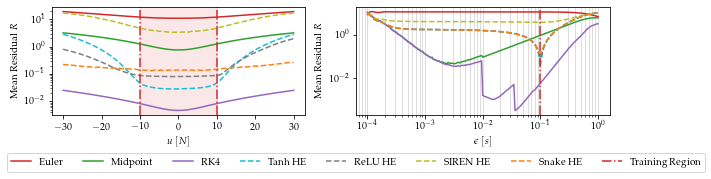

In [ ]:
#########################FIRST PLOT########################## 
fig, axs = plt.subplots(1, 2, figsize=(10,2))

ax = axs[0]
x_min_train, x_max_train = -2*pi, 2*pi
t = 0
Δt = 0.1

# Controller values: originally from -10, 10
n_grid = 100 ; u_b = 30 # 10
u_grid = torch.linspace(-u_b, u_b, n_grid)[..., None]
u_grid = u_grid.repeat(n_grid**2, 1, 1)
u = u_grid


# # Create control inputs to show
# u = torch.arange(-8, 8, 1)
# u = u.reshape(1, torch.numel(u)).repeat(n_grid**2, 1)
# u = u[..., None]

# Create mesh of x
xx = torch.linspace(x_min_train, x_max_train, n_grid)
x0, x1 = torch.meshgrid(xx, xx)
x = torch.cat([x0.reshape(-1, 1), x1.reshape(-1, 1)], 1)
x = x[:, None, :].repeat(1, u.shape[1], 1)


grid = torch.linspace(-u_b, u_b, n_grid)
# Fixed-step solvers
r = compute_residual(t, Δt, x, u, hs_tanh, method='euler').detach()
ax.plot(grid, r.mean(0), color='tab:red', label='Euler')
r = compute_residual(t, Δt, x, u, hs_snake, method='midpoint').detach()
ax.plot(grid, r.mean(0), color='tab:green', label='Midpoint')
r = compute_residual(t, Δt, x, u, hs_snake, method='rk4').detach()
ax.plot(grid, r.mean(0), color='tab:purple', label='RK4')

# Hypersolvers
r = compute_residual(t, Δt, x, u, hs_tanh, model='tanh').detach()
ax.plot(grid, r.mean(0), color='tab:cyan',  linestyle='--',label='Tanh [HE]')
r = compute_residual(t, Δt, x, u, hs_relu, model='relu').detach()
ax.plot(grid, r.mean(0), color='tab:gray',linestyle='--', label='ReLU [HE]')
r = compute_residual(t, Δt, x, u, hs_siren, model='siren').detach()
ax.plot(grid, r.mean(0), color='tab:olive', linestyle='--', label='SIREN [HE]')
r = compute_residual(t, Δt, x, u, hs_snake, model='snake').detach()
ax.plot(grid, r.mean(0), color='tab:orange',linestyle='--', label='Snake [HE]')

ax.axvline(x=-10, color='tab:red', linestyle='-.')
ax.axvline(x=10, color='tab:red', linestyle='-.', label='Training Region')
ax.axvspan(-10, 10, alpha=0.1, color='tab:red')

ax.set_yscale('log')
ax.set_xlabel(f'$u~[N]$')
ax.set_ylabel(f'Mean Residual $R$')

# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
#           fancybox=True, shadow=False, ncol=3)

#########################SECOND PLOT########################## 
ax = axs[1]

x_min_train, x_max_train = -2*pi, 2*pi
t = 0
Δt = 0.1
t_list = torch.logspace(-4, 0, 201)


# Controller values: originally from -10, 10
n_grid = 50 ; u_b = 10 # 10
u_grid = torch.linspace(-u_b, u_b, n_grid)[..., None]
u_grid = u_grid.repeat(n_grid**2, 1, 1)
u = u_grid

# Create mesh of x
xx = torch.linspace(x_min_train, x_max_train, n_grid)
x0, x1 = torch.meshgrid(xx, xx)
x = torch.cat([x0.reshape(-1, 1), x1.reshape(-1, 1)], 1)
x = x[:, None, :].repeat(1, u.shape[1], 1)
def compute_residual_different_steps(t, t_list, x, u, hs, **kwargs):
    r = []
    for dt in tqdm(t_list):
        r.append(compute_residual(t, dt, x, u, hs, **kwargs).detach()[...,None])
    return torch.cat(r, -1)

grid = torch.linspace(-u_b, u_b, n_grid)
# Fixed-step solvers
r = compute_residual_different_steps(t, t_list, x, u, hs_tanh, method='euler').detach()
ax.plot(t_list, r.mean(0).mean(0), color='tab:red', label='Euler')
r = compute_residual_different_steps(t, t_list, x, u, hs_tanh, method='midpoint').detach()
ax.plot(t_list, r.mean(0).mean(0), color='tab:green', label='Midpoint')
r = compute_residual_different_steps(t, t_list, x, u, hs_tanh, method='rk4').detach()
ax.plot(t_list, r.mean(0).mean(0), color='tab:purple', label='RK4')

# # Hypersolvers
r = compute_residual_different_steps(t, t_list, x, u, hs_tanh, model='tanh').detach()
ax.plot(t_list, r.mean(0).mean(0), color='tab:cyan',  linestyle='--',label='Tanh HE')
r = compute_residual_different_steps(t, t_list, x, u, hs_relu, model='relu').detach()
ax.plot(t_list, r.mean(0).mean(0), color='tab:gray',linestyle='--', label='ReLU HE')
r = compute_residual_different_steps(t, t_list, x, u, hs_siren, model='siren').detach()
ax.plot(t_list, r.mean(0).mean(0), color='tab:olive', linestyle='--', label='SIREN HE')
r = compute_residual_different_steps(t, t_list, x, u, hs_snake, model='snake').detach()
ax.plot(t_list, r.mean(0).mean(0), color='tab:orange',linestyle='--', label='Snake HE')

ax.axvline(x=Δt, color='tab:red', linestyle='-.', label='Training Region')
# ax.axvline(x=10, color='red', linestyle='-.', label='Training Region')
# ax.axvspan(-10, 10, alpha=0.1, color='red')


ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(f'$\epsilon~[s]$')
ax.set_ylabel(f'Mean Residual $R$')
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
#           fancybox=True, shadow=False, ncol=3)

# Swag
ax.set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0]) 
plt.grid(True, which="both", axis='x',c='gray', alpha=.33)
locmin = ticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1),numticks=10)  
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(ticker.NullFormatter())

ax.legend(loc='upper center', bbox_to_anchor=(0, -0.3),
          fancybox=True, shadow=False, ncol=8)
# # ## Saving
import tikzplotlib
fig.savefig('media/generalizations_merged.pdf',  bbox_inches = 'tight')
tikzplotlib.save("media/generalizations_merged.tex")